# Shared Memory Parallelism Using OpenMP
We want to use OpenMP to enable parallel execution of our codes. If multiple workers can do the same job, execution will be sped up.

In [1]:
export OMP_NUM_THREADS=10
export OMP_PROC_BIND=close
export OMP_PLACES=cores

In [2]:
pygmentize omp_examples/a01-parallel.F90

program main
    use omp_lib
    implicit none

    integer :: i, seed_size
    real :: a, b
    integer, allocatable :: seed(:)

    call random_seed(size=seed_size)
    allocate(seed(seed_size))
    seed = 712
    call random_seed(put=seed)

    call random_number(a)
    a = int(a * 100)
    write(*,*) a
    write(*,*) ''

    !$omp parallel private(b)
    call random_number(b)
    b = int(b * 100)
    write(*,*) b
    !$omp end parallel

    write(*,*) ''
    write(*,*) 'this is a sequential region again'

end program main


We need to tell the compiler that our program contains OpenMP pragmas with the `-fopenmp` option.

In [3]:
gfortran omp_examples/a01-parallel.F90 -fopenmp -o parallel.out

Now we can run the generated executable.

In [4]:
./parallel.out

   47.0000000    
 
   11.0000000    
   55.0000000    
   52.0000000    
   53.0000000    
   52.0000000    
   61.0000000    
   26.0000000    
   54.0000000    
   61.0000000    
   54.0000000    
 
 this is a sequential region again


<div class="alert alert-block alert-warning">
    We see that each worker is entering the parallel region and executes the code independent of the other workers.<br>
    If we repeat the same block multiple times we see that there is no deterministic answer as the order changes. We see thought that the numbers printed are always the same
</div>    

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>1.</b> Can you explain why the numbers are the same but the order is jumbled up?
    
<b>2.</b> Why do you see the number of outputs?
</div>

<b>ANSWERS</b><p>

1. ...
2. ...

## Infos About the Region
OpenMP allows to get the information about number of threads present in each parallel region

In [5]:
pygmentize omp_examples/a02-infos.F90

program main
    use omp_lib
    implicit none

    integer :: size, rank

    !$omp parallel private(rank, size)
    size = omp_get_num_threads()
    rank = omp_get_thread_num()

    !$omp critical(output)
    write(*,*) 'I am thread ', rank, ' of a total of ', size, ' threads'
    !$omp end critical(output)

    !$omp end parallel

end program main


In [6]:
gfortran omp_examples/a02-infos.F90 -fopenmp -o infos.out && ./infos.out

 I am thread            0  of a total of           10  threads
 I am thread            5  of a total of           10  threads
 I am thread            7  of a total of           10  threads
 I am thread            8  of a total of           10  threads
 I am thread            3  of a total of           10  threads
 I am thread            6  of a total of           10  threads
 I am thread            4  of a total of           10  threads
 I am thread            1  of a total of           10  threads
 I am thread            2  of a total of           10  threads
 I am thread            9  of a total of           10  threads


<div class="alert alert-block alert-warning">
    We can inspect the current thread number and the total number of threads via intrinsics
</div>    

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>3.</b> Can you think of a good reason why this information might be useful?
    
</div>

<b>ANSWERS</b><p>

3. ...

## Setting the Number of Threads
We can do this either on each parallel region or with an environment variable

In [7]:
pygmentize omp_examples/a03-threadnum.F90

program main
    use omp_lib
    implicit none

    integer :: size, rank

    !$omp parallel num_threads(2) private(rank, size)
    size = omp_get_num_threads()
    rank = omp_get_thread_num()

    !$omp critical(output)
    write(*,*) 'I am thread ', rank, ' of a total of ', size, ' threads'
    !$omp end critical(output)

    !$omp end parallel

end program main


In [8]:
gfortran omp_examples/a03-threadnum.F90 -fopenmp -o threadnum.out && ./threadnum.out

 I am thread            0  of a total of            2  threads
 I am thread            1  of a total of            2  threads


<div class="alert alert-block alert-warning">
    We can set the number of threads with the <code>num_threads</code> keyword for parallel regions
</div>

In [9]:
OMP_NUM_THREADS=4 ./infos.out

 I am thread            0  of a total of            4  threads
 I am thread            3  of a total of            4  threads
 I am thread            1  of a total of            4  threads
 I am thread            2  of a total of            4  threads


<div class="alert alert-block alert-warning">
    We can set the number of threads to use when nothing is specified with the <code>OMP_NUM_THREADS</code> environment variable.
</div>

In [10]:
OMP_NUM_THREADS=4 ./threadnum.out

 I am thread            0  of a total of            2  threads
 I am thread            1  of a total of            2  threads


<div class="alert alert-block alert-warning">
    We see that <code>num_threads</code> takes presedence over <code>OMP_NUM_THREADS</code>
</div>

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>4.</b> Why do you think num_threads is higher up in the order of precedence?<br>
<b>5.</b> Why do we need two ways of controlling this? Are these two ways fulfilling the same purpose?
</div>

<b>ANSWERS</b><p>

4. ...
5. ...
    

## Parallel Loops
Since loops are such an important concept to parallelize, there is a special directive for it.

In [11]:
pygmentize omp_examples/a04-loops.F90

program main
    use omp_lib
    implicit none

    integer :: i

    !$omp parallel do
    do i = 0, 9
        !$omp critical(output)
        write(*,*) 'This is iteration ', i, ' executed from thread ', omp_get_thread_num()
        !$omp end critical(output)
    end do
    !$omp end parallel do

end program main


In [12]:
gfortran omp_examples/a04-loops.F90 -fopenmp -o loops.out

In [13]:
OMP_NUM_THREADS=4 ./loops.out

 This is iteration            6  executed from thread            2
 This is iteration            7  executed from thread            2
 This is iteration            0  executed from thread            0
 This is iteration            1  executed from thread            0
 This is iteration            2  executed from thread            0
 This is iteration            8  executed from thread            3
 This is iteration            9  executed from thread            3
 This is iteration            3  executed from thread            1
 This is iteration            4  executed from thread            1
 This is iteration            5  executed from thread            1


<div class="alert alert-block alert-warning">
    We see that the loop order is not preserved, threads take diffent amout of iterations and are not sorted
</div>

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>6.</b> Since this is an existing concept it has it's applications. Can you think of a simple example where the loop order does not matter? Can you also think of one where an unordered loop will break the program flow?<br>
    
</div>

<b>ANSWERS</b><p>

6. ...

In [14]:
OMP_NUM_THREADS=12 ./loops.out

 This is iteration            0  executed from thread            0
 This is iteration            1  executed from thread            1
 This is iteration            9  executed from thread            9
 This is iteration            2  executed from thread            2
 This is iteration            3  executed from thread            3
 This is iteration            4  executed from thread            4
 This is iteration            5  executed from thread            5
 This is iteration            6  executed from thread            6
 This is iteration            8  executed from thread            8
 This is iteration            7  executed from thread            7


<div class="alert alert-block alert-warning">
    If more threads than loop iterations are available, only the first set of threads is used
</div>

## Scheduling
<div class="alert alert-block alert-danger">
This is an important concept to understand but is not necessarily used in our example
</div>

Controlling the loop execution with the `schedule` directive might be important for performance. Since the work is oftentimes similar in weather and climate codes this is not super important for our example but is still a concept worth knowing.

In [15]:
pygmentize omp_examples/a05-schedule.F90

program main
    use omp_lib
    implicit none

    integer :: i

    write(*,*) 'schedule(static, 2)'

    !$omp parallel do schedule(static, 2)
    do i = 0, 9
        !$omp critical(output)
        write(*,*) 'This is iteration ', i, ' executed from thread ', omp_get_thread_num()
        !$omp end critical(output)
    end do
    !$omp end parallel do

    write(*,*) 'schedule(static, 1)'

    !$omp parallel do schedule(static, 1)
    do i = 0, 9
        !$omp critical(output)
        write(*,*) 'This is iteration ', i, ' executed from thread ', omp_get_thread_num()
        !$omp end critical(output)
    end do
    !$omp end parallel do

end program main


In [16]:
gfortran omp_examples/a05-schedule.F90 -fopenmp -o schedule.out

In [17]:
OMP_NUM_THREADS=2 ./schedule.out

 schedule(static, 2)
 This is iteration            0  executed from thread            0
 This is iteration            1  executed from thread            0
 This is iteration            4  executed from thread            0
 This is iteration            5  executed from thread            0
 This is iteration            8  executed from thread            0
 This is iteration            9  executed from thread            0
 This is iteration            2  executed from thread            1
 This is iteration            3  executed from thread            1
 This is iteration            6  executed from thread            1
 This is iteration            7  executed from thread            1
 schedule(static, 1)
 This is iteration            1  executed from thread            1
 This is iteration            3  executed from thread            1
 This is iteration            5  executed from thread            1
 This is iteration            7  executed from thread            1
 This is iteration  

<div class="alert alert-block alert-warning">
    Static scheduling allows us to assign chunks of the iteration to the same thread
</div>

## Variable Scoping
We try to understand how variables are scoped, who owns them at which parts of the code and who can see effects of writing them.

In [18]:
pygmentize omp_examples/a06-scoping.F90

program main
    use omp_lib
    implicit none

    integer :: i, myvar
    myvar = -1

    !$omp parallel do num_threads(3)
    do i = 0, 9
        myvar = i
        !$omp critical(output)
        write(*,*) 'i is ', i, ' and myvar is ', myvar
        !$omp end critical(output)
    end do
    !$omp end parallel do

    write(*,*) 'myvar: ', myvar

end program main


In [19]:
gfortran omp_examples/a06-scoping.F90 -fopenmp -o scoping.out

In [20]:
./scoping.out

 i is            0  and myvar is            7
 i is            1  and myvar is            1
 i is            2  and myvar is            2
 i is            3  and myvar is            3
 i is            7  and myvar is            3
 i is            8  and myvar is            8
 i is            9  and myvar is            9
 i is            4  and myvar is            9
 i is            5  and myvar is            5
 i is            6  and myvar is            6
 myvar:            6


<div class="alert alert-block alert-warning">
    We see that shared variables can cause race conditions
</div>

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>7.</b> Run the above code 5 times. What do you observe?<br>
<b>8.</b> Why is the code above problematic? Is what we're doing here still compatible with the Turing Machine way of modelling computers?
    
</div>

<b>ANSWERS</b><p>

7. ...
8. ...

The private directive allows each thread to have a copy of a variable: 

In [21]:
pygmentize omp_examples/a07-private.F90

program main
    use omp_lib
    implicit none

    integer :: i, myvar

    myvar = 42

    !$omp parallel do private(myvar)
    do i = 0, 9
        !$omp critical(output)
        write(*,*) 'before writing:', ' i is ', i, ' and myvar is ', myvar
        !$omp end critical(output)

        myvar = i

        !$omp critical(output)
        write(*,*) 'after writing:', ' i is ', i, ' and myvar is ', myvar
        !$omp end critical(output)
    end do
    !$omp end parallel do

    write(*,*) 'myvar: ', myvar

end program main


In [22]:
gfortran omp_examples/a07-private.F90 -fopenmp -o private.out

In [23]:
OMP_NUM_THREADS=10 ./private.out

 before writing: i is            7  and myvar is            0
 after writing: i is            7  and myvar is            7
 before writing: i is            3  and myvar is            0
 after writing: i is            3  and myvar is            3
 before writing: i is            4  and myvar is            0
 after writing: i is            4  and myvar is            4
 before writing: i is            1  and myvar is            0
 after writing: i is            1  and myvar is            1
 before writing: i is            2  and myvar is            0
 after writing: i is            2  and myvar is            2
 before writing: i is            6  and myvar is            0
 after writing: i is            6  and myvar is            6
 before writing: i is            5  and myvar is            0
 after writing: i is            5  and myvar is            5
 before writing: i is            0  and myvar is            0
 before writing: i is            8  and myvar is            0
 after writing:

<div class="alert alert-block alert-warning">
    We see:
    <ul>
        <li>Private variables are always empty when coming in to the parallel regions</li>
        <li>Private variables do not cause race conditions</li>
        <li>The values in private variables are lost after exiting the parallel region</li>
    </ul>
</div>

shared is the default but can also be stated explicitly

In [24]:
pygmentize omp_examples/a08-shared.F90

program main
    use omp_lib
    implicit none

    integer :: i, myvar
    myvar = -1

    !$omp parallel do shared(myvar)
    do i = 0, 9
        !$omp critical(output)
        write(*,*) 'before writing: i is ', i, ' and myvar is ', myvar
        !$omp end critical(output)

        myvar = i

        !$omp critical(output)
        write(*,*) 'after writing: i is ', i, ' and myvar is ', myvar
        !$omp end critical(output)
    end do
    !$omp end parallel do

    write(*,*) 'myvar: ', myvar

end program main


In [25]:
gfortran omp_examples/a08-shared.F90 -fopenmp -o shared.out

In [26]:
OMP_NUM_THREADS=10 ./shared.out

 before writing: i is            0  and myvar is           -1
 after writing: i is            0  and myvar is            0
 before writing: i is            7  and myvar is            0
 after writing: i is            7  and myvar is            7
 before writing: i is            8  and myvar is            7
 after writing: i is            8  and myvar is            8
 before writing: i is            5  and myvar is            8
 after writing: i is            5  and myvar is            5
 before writing: i is            4  and myvar is            5
 after writing: i is            4  and myvar is            4
 before writing: i is            9  and myvar is            4
 after writing: i is            9  and myvar is            9
 before writing: i is            6  and myvar is            9
 after writing: i is            6  and myvar is            6
 before writing: i is            3  and myvar is            6
 after writing: i is            3  and myvar is            3
 before writing:

<div class="alert alert-block alert-warning">
    We find a way to explicitly use shared variables in parallel regions
</div>

## Special Regions
<div class="alert alert-block alert-danger">
This is an important concept to understand but is not necessarily used in our example
</div>

There are certain pieces of the code that might be more sensitive to how threads should be handling them, here are the options:

In [27]:
pygmentize omp_examples/a09-regions.F90

program main
    use omp_lib
    implicit none

    integer :: size, rank

    !$omp parallel private(size, rank)
    size = omp_get_num_threads()
    rank = omp_get_thread_num()

    !$omp single
    write(*,*) 'thread ', rank, ' is present in single'
    write(*,*) 'and the size here is : ', omp_get_num_threads()
    !$omp end single

    !$omp master
    write(*,*) 'thread ', rank, ' is present in master'
    !$omp end master

    !$omp critical(somethingHard)
    write(*,*) 'thread ', rank, ' is present in critical'
    !$omp end critical(somethingHard)

    !$omp end parallel

end program main


In [28]:
gfortran omp_examples/a09-regions.F90 -fopenmp -o regions.out && ./regions.out

 thread            5  is present in single
 and the size here is :           10
 thread            9  is present in critical
 thread            5  is present in critical
 thread            6  is present in critical
 thread            1  is present in critical
 thread            8  is present in critical
 thread            7  is present in critical
 thread            3  is present in critical
 thread            4  is present in critical
 thread            2  is present in critical
 thread            0  is present in master
 thread            0  is present in critical


<div class="alert alert-block alert-warning">
    We learn that thread 0 is the only one entering <code>master</code>, only one thread ever enters <code>single</code> and every thread enters <code>critical</code>, but only one at a time
</div>

## What if parallel regions span multiple tasks
<div class="alert alert-block alert-danger">
This is an important concept to understand but is not necessarily used in our example
</div>

Depending on how parallelization was done there might be a need to let threads wait for each other. The `#pragma omp barrier` is used for that.

In [29]:
pygmentize omp_examples/a10-barrier.F90

program main
    use omp_lib
    implicit none

    integer :: size, rank

    !$omp parallel num_threads(5) private(size, rank)
    size = omp_get_num_threads()
    rank = omp_get_thread_num()

    !$omp critical(somethingHard)
    write(*,*) 'thread ', rank, ' is present in critical1'
    !$omp end critical(somethingHard)

    !$omp critical(somethingEasy)
    write(*,*) 'thread ', rank, ' is present in critical2'
    !$omp end critical(somethingEasy)

    !$omp end parallel

end program main


In [30]:
gfortran omp_examples/a10-barrier.F90 -fopenmp -o barrier.out && ./barrier.out

 thread            2  is present in critical1
 thread            2  is present in critical2
 thread            3  is present in critical1
 thread            3  is present in critical2
 thread            4  is present in critical1
 thread            4  is present in critical2
 thread            1  is present in critical1
 thread            1  is present in critical2
 thread            0  is present in critical1
 thread            0  is present in critical2


<div class="alert alert-block alert-warning">
    We learn that there is no guarantee on the execution order of different statements in a parallel block across threads
</div>

In [31]:
pygmentize omp_examples/a11-barrier.F90

program main
    use omp_lib
    implicit none

    integer :: size, rank

    !$omp parallel num_threads(5) private(size, rank)
    size = omp_get_num_threads()
    rank = omp_get_thread_num()

    !$omp critical(somethingHard)
    write(*,*) 'thread ', rank, ' is present in critical1'
    !$omp end critical(somethingHard)

    !$omp barrier

    !$omp critical(somethingEasy)
    write(*,*) 'thread ', rank, ' is present in critical2'
    !$omp end critical(somethingEasy)

    !$omp end parallel

end program main


In [32]:
gfortran omp_examples/a11-barrier.F90 -fopenmp -o barrier2.out && ./barrier2.out

 thread            0  is present in critical1
 thread            2  is present in critical1
 thread            1  is present in critical1
 thread            3  is present in critical1
 thread            4  is present in critical1
 thread            2  is present in critical2
 thread            0  is present in critical2
 thread            1  is present in critical2
 thread            3  is present in critical2
 thread            4  is present in critical2


<div class="alert alert-block alert-warning">
    We learn that barriers help synchronize code
</div>

## Nowait
<div class="alert alert-block alert-danger">
This is an important concept to understand but is not necessarily used in our example
</div>

Certain OpenMP statements come with implicit barriers so `nowait` is the keyword to explicitly disable those

In [33]:
pygmentize omp_examples/a12-loops.F90

program main
    use omp_lib
    implicit none

    integer :: i, size, rank

    !$omp parallel num_threads(3) private(size, rank, i)
    size = omp_get_num_threads()
    rank = omp_get_thread_num()

    !$omp do
    do i = 0, 5
        write(*,*) 'loop 1, iteration ', i
    end do
    !$omp end do

    !$omp do
    do i = 0, 5
        write(*,*) 'loop 2, iteration ', i
    end do
    !$omp end do

    !$omp end parallel

end program main


In [34]:
gfortran omp_examples/a12-loops.F90 -fopenmp -o loops.out && ./loops.out

 loop 1, iteration            0
 loop 1, iteration            1
 loop 1, iteration            4
 loop 1, iteration            5
 loop 1, iteration            2
 loop 1, iteration            3
 loop 2, iteration            4
 loop 2, iteration            5
 loop 2, iteration            0
 loop 2, iteration            1
 loop 2, iteration            2
 loop 2, iteration            3


<div class="alert alert-block alert-warning">
    We learn that loops synchrnoize afterwards
</div>

In [35]:
pygmentize omp_examples/a13-nowait.F90

program main
    use omp_lib
    implicit none

    integer :: i, size, rank

    !$omp parallel num_threads(3) private(size, rank, i)
    size = omp_get_num_threads()
    rank = omp_get_thread_num()

    !$omp do
    do i = 0, 5
        write(*,*) 'loop 1, iteration ', i
    end do
    !$omp end do nowait

    !$omp do
    do i = 0, 5
        write(*,*) 'loop 2, iteration ', i
    end do
    !$omp end do nowait

    !$omp end parallel

end program main


In [36]:
gfortran omp_examples/a13-nowait.F90 -fopenmp -o nowait.out && ./nowait.out

 loop 1, iteration            0
 loop 1, iteration            1
 loop 2, iteration            0
 loop 2, iteration            1
 loop 1, iteration            4
 loop 1, iteration            5
 loop 2, iteration            4
 loop 2, iteration            5
 loop 1, iteration            2
 loop 1, iteration            3
 loop 2, iteration            2
 loop 2, iteration            3


<div class="alert alert-block alert-warning">
    We learn that the nowait keyword can remove synchonizaton
</div>

## Reductions
<div class="alert alert-block alert-danger">
This is an important concept to understand but is not necessarily used in our example
</div>

Since reductions are such an omnipresent motif, we do not want to implement it with critical / atomic every time, so there is a keyword for it:

In [37]:
pygmentize omp_examples/a14-reduction.F90

program main
    use omp_lib
    implicit none

    integer :: t
    double precision :: sum

    sum = 0.0

    !$omp parallel do reduction(+:sum)
    do t = 0, 9
        sum = sum + t
    end do
    !$omp end parallel do

    write(*,*) sum

end program main


In [38]:
gfortran omp_examples/a14-reduction.F90 -fopenmp -o reduction.out && ./reduction.out

   45.000000000000000     


<div class="alert alert-block alert-warning">
    We learn about the reduction keyword
</div>

# Amdahl's law

We try to investigate the performance of a simple example, computing $\pi$ using the Leibniz formula:

$$1 - \frac{1}{3} + \frac{1}{5} - \frac{1}{7} + \frac{1}{9} ... = \frac{\pi}{4}$$

Our goal is to understand what might affect performance and how this is reflected in strong and weak scaling plots

## Strong Scaling

Understanding how much faster the code gets though parallelization

In [39]:
pygmentize omp_examples/b01-timing.F90

program main
    use omp_lib
    implicit none

    integer :: nThreads, steps, t
    double precision :: tic, toc, sum
    character(len=20) :: arg

    call get_command_argument(1, arg)
    read(arg,*) nThreads

    call omp_set_num_threads(nThreads)

    tic = omp_get_wtime()

    steps = 10000000
    sum = 0.0

    !$omp parallel do reduction(+:sum)
    do t = 0, steps - 1
        sum = sum + (1.0d0 - 2.0d0 * mod(t, 2)) / (2 * t + 1)
    end do
    !$omp end parallel do

    toc = omp_get_wtime()

    !$omp parallel
    if (omp_get_thread_num() == 0) then
        write(*,*) omp_get_num_threads(), toc - tic
    end if
    !$omp end parallel

end program main


In [40]:
gfortran -fopenmp omp_examples/b01-timing.F90 -o timing.out

In [41]:
echo -n > out.txt
for nthread in `seq 12` ; do
  ./timing.out $nthread >> out.txt
done

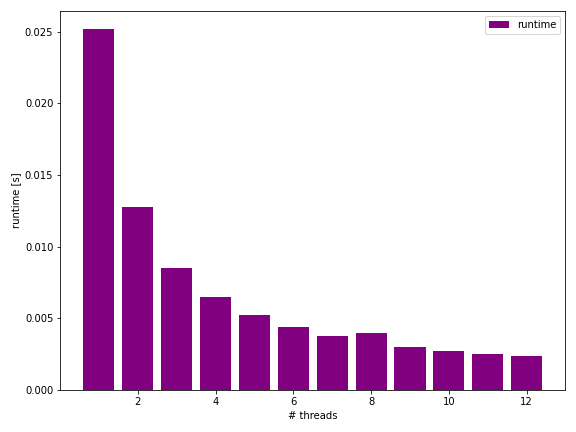

In [42]:
python -c "
import matplotlib
matplotlib.use('Agg')
import numpy as np, matplotlib.pyplot as plt;
data = np.loadtxt('out.txt');
threads = data[:,0].astype(int); runtimes = data[:,1];
plt.figure(figsize=(8,6));
plt.bar(threads, runtimes, color='purple', label='runtime');
plt.xlabel('# threads'); plt.ylabel('runtime [s]'); plt.legend(); plt.tight_layout();
plt.savefig('out.png', dpi=72)
"

cat out.png | display

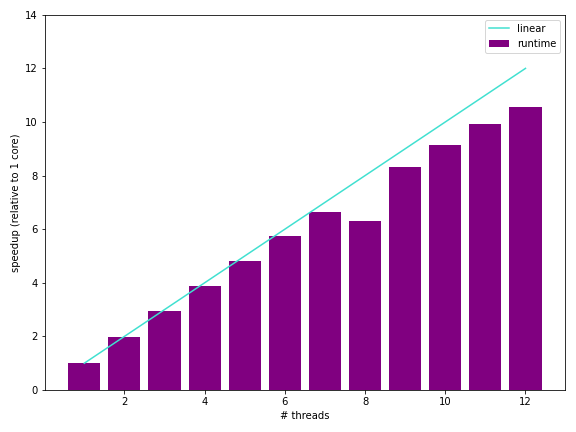

In [43]:
python -c "
import matplotlib
matplotlib.use('Agg')
import numpy as np, matplotlib.pyplot as plt
data = np.loadtxt('out.txt')
threads = data[:, 0].astype(int)
runtimes = data[:, 1]
base_runtime = runtimes[0]
speedup = base_runtime / runtimes
linear = threads
plt.figure(figsize=(8,6))
plt.bar(threads, speedup, color='purple', label='runtime')
plt.plot(threads, linear, color='turquoise', label='linear')
plt.xlabel('# threads')
plt.ylabel('speedup (relative to 1 core)')
plt.ylim(0, 14)
plt.legend()
plt.tight_layout()
plt.savefig('out.png', dpi=72)
"

cat out.png | display

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>9.</b> Can you explain the performance numbers that we see here? What effects are in place?<br>    
</div>

<b>ANSWERS</b><p>

9. ...


## Weak scaling
Measuring the performance hit we get by increasing the problem size as well as the number of threads

In [44]:
pygmentize omp_examples/b02-weakscaling.F90

program main
    use omp_lib
    implicit none

    integer :: nThreads, steps, t
    double precision :: tic, toc, sum
    character(len=20) :: arg

    call get_command_argument(1, arg)
    read(arg,*) nThreads

    steps = 10000000 * nThreads
    sum = 0.0

    call omp_set_num_threads(nThreads)

    tic = omp_get_wtime()

    ! Parallel loop with reduction on sum
    !$omp parallel do reduction(+:sum)
    do t = 0, steps - 1
        sum = sum + (1.0d0 - 2.0d0 * mod(t, 2)) / (2 * t + 1)
    end do
    !$omp end parallel do

    toc = omp_get_wtime()

    ! Print the number of threads and the elapsed time
    !$omp parallel
    if (omp_get_thread_num() == 0) then
        write(*,*) omp_get_num_threads(), toc - tic
    end if
    !$omp end parallel

end program main


In [45]:
gfortran -fopenmp omp_examples/b02-weakscaling.F90 -o weak.out

In [46]:
echo -n > weak.txt
for nthread in `seq 72` ; do
    ./weak.out $nthread >> weak.txt
done

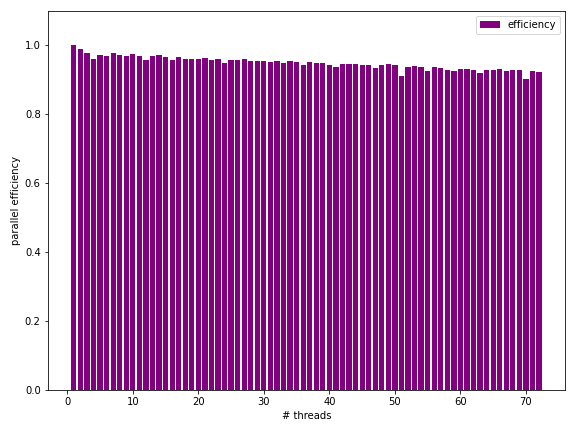

In [47]:
python -c "
import matplotlib
matplotlib.use('Agg')
import numpy as np, matplotlib.pyplot as plt
data = np.loadtxt('weak.txt')
threads = data[:, 0].astype(int)
runtimes = data[:, 1]
base_runtime = runtimes[0]
efficiency = (base_runtime / runtimes)
plt.figure(figsize=(8,6))
plt.bar(threads, efficiency, color='purple', label='efficiency')
plt.xlabel('# threads')
plt.ylabel('parallel efficiency')
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.savefig('out.png', dpi=72)
"

cat out.png | display

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>10.</b> Can you explain the performance numbers that we see here? What effects are in place?<br>
</div>

<b>ANSWERS</b><p>

10. ...


## Caching

Here we see the implication of caching in a multithreaded environment

In [48]:
pygmentize omp_examples/b03-caching.F90

program main
    use omp_lib
    implicit none

    integer, parameter :: n = 10000000
    integer :: nThreads, i
    double precision :: tic, toc
    double precision, dimension(n) :: input, output
    character(len=20) :: arg

    input = 1.0d0
    output = 0.0d0

    call get_command_argument(1, arg)
    read(arg,*) nThreads

    call omp_set_num_threads(nThreads)

    tic = omp_get_wtime()

    !$omp parallel do schedule(static, 1)
    do i = 1, n
        output(i) = 2.0d0 * input(i)
        input(i) = 0.0d0
    end do
    !$omp end parallel do

    toc = omp_get_wtime()

    !$omp parallel
    if (omp_get_thread_num() == 0) then
        write(*,*) omp_get_num_threads(), toc - tic
    end if
    !$omp end parallel

end program main


In [49]:
gfortran -fopenmp omp_examples/b03-caching.F90 -o caching.out

In [50]:
echo -n > caching.txt
for nthread in `seq 72` ; do
  ./caching.out $nthread >> caching.txt
done

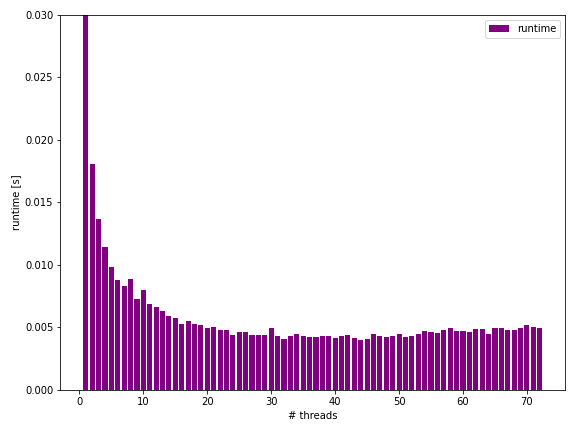

In [51]:
python -c "
import matplotlib
matplotlib.use('Agg')
import numpy as np, matplotlib.pyplot as plt
data = np.loadtxt('caching.txt')
threads = data[:, 0].astype(int)
runtimes = data[:, 1]
plt.figure(figsize=(8,6))
plt.bar(threads, runtimes, color='purple', label='runtime')
plt.xlabel('# threads')
plt.ylabel('runtime [s]')
plt.ylim(0, 0.03)
plt.legend()
plt.tight_layout()
plt.savefig('out.png', dpi=72)
"

cat out.png | display

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>11.</b> Can you explain the performance numbers that we see here? What effects are in place?<br>
</div>

<b>ANSWERS</b><p>

11. ...

In [52]:
pygmentize omp_examples/b04-caching_fast.F90

program main
    use omp_lib
    implicit none

    integer, parameter :: n = 10000000
    integer :: nThreads, i
    double precision :: tic, toc
    double precision, dimension(n) :: input, output
    character(len=20) :: arg

    input = 1.0d0
    output = 0.0d0

    call get_command_argument(1, arg)
    read(arg,*) nThreads

    call omp_set_num_threads(nThreads)

    tic = omp_get_wtime()

    !$omp parallel do schedule(static, 10000)
    do i = 1, n
        output(i) = 2.0d0 * input(i)
        input(i) = 0.0d0
    end do
    !$omp end parallel do

    toc = omp_get_wtime()

    !$omp parallel
    if (omp_get_thread_num() == 0) then
        write(*,*) omp_get_num_threads(), toc - tic
    end if
    !$omp end parallel

end program main


In [53]:
gfortran -fopenmp omp_examples/b04-caching_fast.F90 -o caching2.out

In [54]:
echo -n > caching2.txt
for nthread in `seq 72` ; do
  ./caching2.out $nthread >> caching2.txt
done

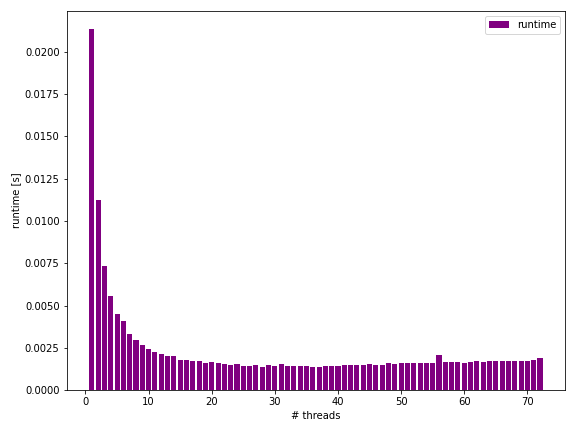

In [55]:
python -c "
import matplotlib
matplotlib.use('Agg')
import numpy as np, matplotlib.pyplot as plt
data = np.loadtxt('caching2.txt')
threads = data[:, 0].astype(int)
runtimes = data[:, 1]
plt.figure(figsize=(8,6))
plt.bar(threads, runtimes, color='purple', label='runtime')
plt.xlabel('# threads')
plt.ylabel('runtime [s]')
#plt.ylim(0, 0.03)
plt.legend()
plt.tight_layout()
plt.savefig('out.png', dpi=72)
"

cat out.png | display

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>12.</b> Can you explain the performance numbers that we see here? What effects are in place?<br>
</div>

<b>ANSWERS</b><p>

12. ...

In [56]:
make clean_examples

rm -f *.out weak.txt caching.txt caching2.txt out.txt out.png
